In [1]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# Set the desired folder path inside your Google Drive
folder_path = '/content/drive/MyDrive/Image_denoising'

# Change the working directory to the desired folder
os.chdir(folder_path)

In [3]:
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Image_denoising


In [4]:
import numpy as np
import cv2

# Path to the folder containing the images
import os
import cv2
import numpy as np

folder_path = '/content/drive/MyDrive/Image_denoising/Train/high'

# List to store the image arrays
image_arrays = []

# Get a sorted list of all image files in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Loop through the sorted list of image files
for filename in image_files:
    # Read the image using OpenCV
    image = cv2.imread(os.path.join(folder_path, filename))
    # Convert the image to grayscale (optional, if needed)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Append the image array to the list
    image_arrays.append(image)

# Convert the list of arrays to a single numpy array
image_arrays_np = np.array(image_arrays)

# Check the shape of the numpy array
print(image_arrays_np.shape)



(485, 400, 600, 3)


In [5]:
folder_path_2 = '/content/drive/MyDrive/Image_denoising/Train/low'

# List to store the image arrays
noised_image = []
image_files_2 = sorted([f for f in os.listdir(folder_path_2) if f.endswith('.jpg') or f.endswith('.png')])
# Loop through all the image files in the folder
for filename in image_files_2:
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Add more extensions if needed
        # Read the image using OpenCV
        image = cv2.imread(os.path.join(folder_path_2, filename))
        # Convert the image to grayscale (optional, if needed)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Append the image array to the list
        noised_image.append(image)

# Convert the list of arrays to a single numpy array
noised_arrays_np = np.array(noised_image)

# Check the shape of the numpy array
print("Shape of the array:", noised_arrays_np.shape)

Shape of the array: (485, 400, 600, 3)


In [32]:

# Function to resize a single image
def resize_image(image, target_size=(300,200)):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

# Example with a batch of images
def resize_images(images, target_size=(300,200)):
    return np.array([resize_image(image, target_size) for image in images])

# Resize the image arrays
resized_image_arrays_np = resize_images(image_arrays_np)
resized_noised_arrays_np = resize_images(noised_arrays_np)

In [33]:
import matplotlib.pyplot as plt


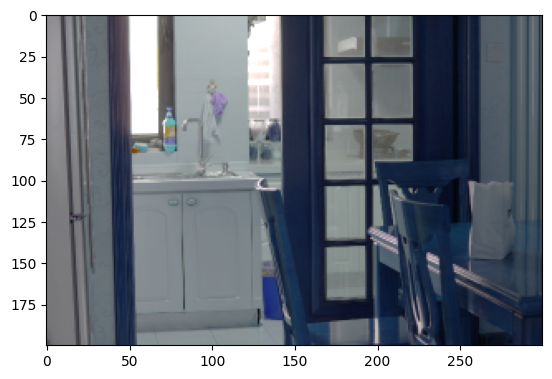

In [34]:
plt.imshow(resized_image_arrays_np[5])

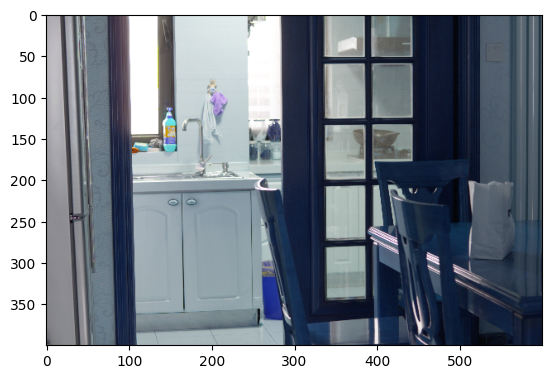

In [35]:
plt.imshow(image_arrays_np[2])

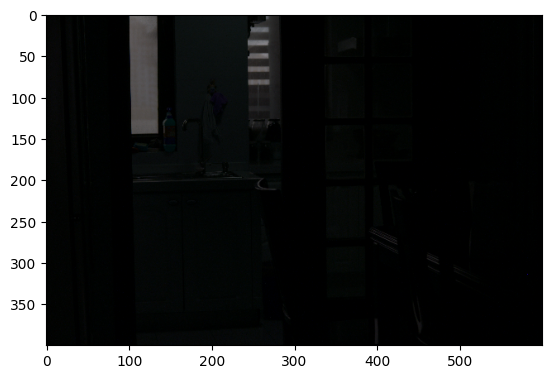

In [36]:
plt.imshow(noised_arrays_np[5])

In [37]:
noisy_images = resized_noised_arrays_np.astype('float32') / 255.0
clean_images = resized_image_arrays_np.astype('float32') / 255.0


In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add, ReLU

def residual_block(input_tensor, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    return Add()([input_tensor, x])

def build_edsr_model(input_shape, num_residual_blocks=16, filters=64, kernel_size=3):
    input_img = Input(shape=input_shape)

    # Initial Conv layer
    x = Conv2D(filters, kernel_size, padding='same')(input_img)
    x = ReLU()(x)

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, kernel_size)

    # Final Conv layer
    x = Conv2D(input_shape[-1], kernel_size, padding='same')(x)

    # Residual learning
    output_img = Add()([input_img, x])

    # Build and compile the model
    edsr = Model(input_img, output_img)
    # edsr.compile(optimizer='adam', loss='mean_squared_error')

    return edsr

# Define the input shape based on your images
input_shape = (200, 300, 3)
edsr = build_edsr_model(input_shape)

# Display the model architecture
edsr.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 200, 300, 3)]        0         []                            
                                                                                                  
 conv2d_91 (Conv2D)          (None, 200, 300, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 re_lu_17 (ReLU)             (None, 200, 300, 64)         0         ['conv2d_91[0][0]']           
                                                                                                  
 conv2d_92 (Conv2D)          (None, 200, 300, 64)         36928     ['re_lu_17[0][0]']            
                                                                                            

In [41]:
train_ratio = 0.8
train_size = int(train_ratio * noisy_images.shape[0])

train_noisy, test_noisy = noisy_images[:train_size], noisy_images[train_size:]
train_clean, test_clean = clean_images[:train_size], clean_images[train_size:]

In [42]:
train_noisy.shape

(388, 200, 300, 3)

In [43]:
train_clean.shape

(388, 200, 300, 3)

In [44]:
# Compile the model
edsr.compile(optimizer='adam', loss='mean_squared_error')

# Define a custom training loop if gradient accumulation is needed
accum_steps = 8  # Number of accumulation steps

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(images, labels, accum_grads):
    with tf.GradientTape() as tape:
        predictions = edsr(images, training=True)
        loss = loss_fn(labels, predictions)

    gradients = tape.gradient(loss, edsr.trainable_variables)
    for i in range(len(accum_grads)):
        accum_grads[i].assign_add(gradients[i])

    return loss

# Sample training data
train_dataset = tf.data.Dataset.from_tensor_slices((train_noisy , train_clean))
train_dataset = train_dataset.batch(1)

# Training loop
for epoch in range(10):  # Number of epochs
    accum_grads = [tf.Variable(tf.zeros_like(var), trainable=False) for var in edsr.trainable_variables]
    for step, (images, labels) in enumerate(train_dataset):
        loss = train_step(images, labels, accum_grads)

        if (step + 1) % accum_steps == 0:
            optimizer.apply_gradients(zip(accum_grads, edsr.trainable_variables))
            accum_grads = [tf.Variable(tf.zeros_like(var), trainable=False) for var in edsr.trainable_variables]
            print(f"Epoch {epoch + 1}, Step {step + 1}, Loss: {loss.numpy()}")


Epoch 1, Step 8, Loss: 0.2373521625995636
Epoch 1, Step 16, Loss: 21.56580924987793
Epoch 1, Step 24, Loss: 0.3817202150821686
Epoch 1, Step 32, Loss: 0.035592008382081985
Epoch 1, Step 40, Loss: 2.361985921859741
Epoch 1, Step 48, Loss: 0.18847084045410156
Epoch 1, Step 56, Loss: 0.13489197194576263
Epoch 1, Step 64, Loss: 1.093737244606018
Epoch 1, Step 72, Loss: 0.09046220779418945
Epoch 1, Step 80, Loss: 0.24828356504440308
Epoch 1, Step 88, Loss: 0.061852917075157166
Epoch 1, Step 96, Loss: 0.060308340936899185
Epoch 1, Step 104, Loss: 0.03552237153053284
Epoch 1, Step 112, Loss: 0.1396111398935318
Epoch 1, Step 120, Loss: 0.02462931163609028
Epoch 1, Step 128, Loss: 0.049796104431152344
Epoch 1, Step 136, Loss: 0.02353469282388687
Epoch 1, Step 144, Loss: 0.1403113454580307
Epoch 1, Step 152, Loss: 0.11488694697618484
Epoch 1, Step 160, Loss: 0.08011001348495483
Epoch 1, Step 168, Loss: 0.07045409828424454
Epoch 1, Step 176, Loss: 0.047838013619184494
Epoch 1, Step 184, Loss: 0.0

In [27]:
dncnn.fit(train_noisy, train_clean, epochs=15, batch_size=32)

Epoch 1/15
13/13 [==============================] - 31s 1s/step - loss: 0.2756
Epoch 2/15
13/13 [==============================] - 15s 1s/step - loss: 0.0414
Epoch 3/15
13/13 [==============================] - 15s 1s/step - loss: 0.0328
Epoch 4/15
13/13 [==============================] - 15s 1s/step - loss: 0.0307
Epoch 5/15
13/13 [==============================] - 15s 1s/step - loss: 0.0301
Epoch 6/15
13/13 [==============================] - 15s 1s/step - loss: 0.0365
Epoch 7/15
13/13 [==============================] - 15s 1s/step - loss: 0.0320
Epoch 8/15
13/13 [==============================] - 15s 1s/step - loss: 0.0293
Epoch 9/15
13/13 [==============================] - 15s 1s/step - loss: 0.0274
Epoch 10/15
13/13 [==============================] - 15s 1s/step - loss: 0.0302
Epoch 11/15
13/13 [==============================] - 15s 1s/step - loss: 0.0295
Epoch 12/15
13/13 [==============================] - 15s 1s/step - loss: 0.0292
Epoch 13/15
13/13 [==============================

In [45]:
denoised_image=edsr.predict(test_noisy)

4/4 [==============================] - 9s 694ms/step


In [ ]:
denoised_image.shape

(97, 160, 240, 3)

In [ ]:
test_clean.shape

(97, 160, 240, 3)

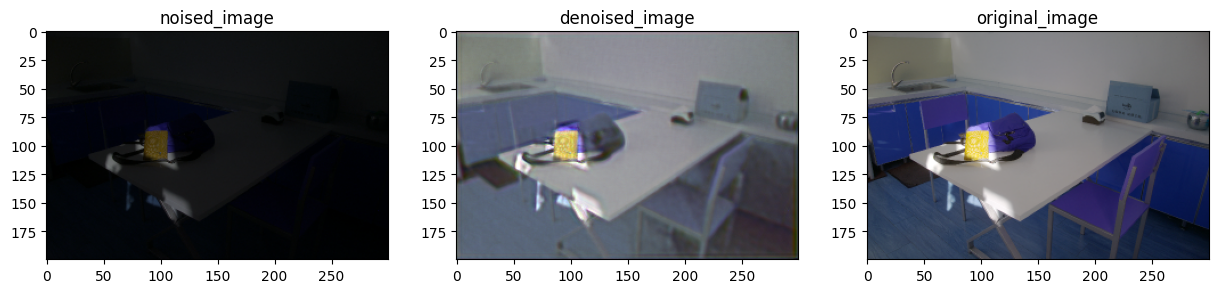

In [46]:
fig , axe= plt.subplots(1,3,figsize=(15,5))
i=1
axe[0].imshow(test_noisy[i])
axe[0].set_title('noised_image')
axe[1].imshow(denoised_image[i])
axe[1].set_title('denoised_image')
axe[2].imshow(test_clean[i])
axe[2].set_title('original_image')
plt.show()

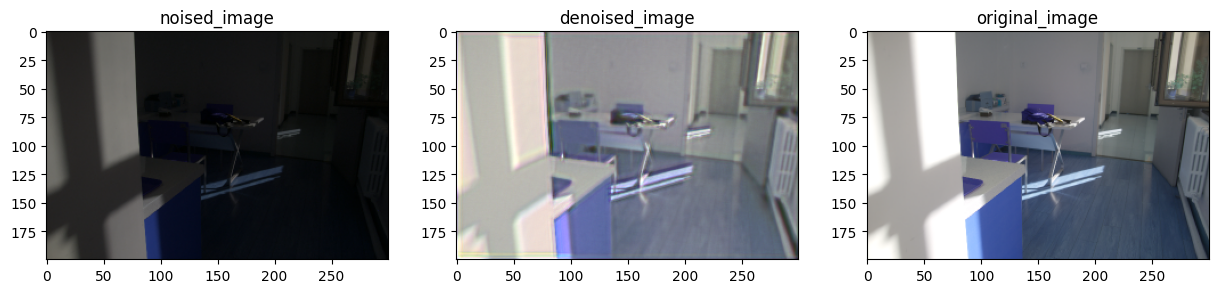

In [47]:
fig , axe= plt.subplots(1,3,figsize=(15,5))
i=4
axe[0].imshow(test_noisy[i])
axe[0].set_title('noised_image')
axe[1].imshow(denoised_image[i])
axe[1].set_title('denoised_image')
axe[2].imshow(test_clean[i])
axe[2].set_title('original_image')
plt.show()

In [48]:


def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel_value = 1.0  # Since the images are normalized
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr


In [49]:
psnr_values = [calculate_psnr(test_clean[i], denoised_image[i]) for i in range(len(test_clean))]
average_psnr = np.mean(psnr_values)
print(f"Average PSNR value is: {average_psnr} dB")



Average PSNR value is: 17.093663485629676 dB


In [50]:
edsr.save('model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
